# Project 5 - Intro to Deep Learning Image Classification

### What to Submit
Submit this iPython Notebook--containing all your code for the programming exercises below--on [LearningSuite](https://learningsuite.byu.edu/).

Your notebook file should produce the relevant plots and also provide a short write-up with answers to the questions below (at the end of this notebook).

<span style="color:red">PLEASE submit only the notebook -- no additional files.</span>

Please also fill in here the time that each part took you:
1. Part A - Dataset: <span style="color:red;">13 hrs</span>
2. Part B - Neural Network Architecture: <span style="color:red;">10 mins</span>
3. Part C - Network Training: <span style="color:red;">3 hrs</span>
4. Part D - Testing: <span style="color:red;">3 hrs</span>
5. Write-up: <span style="color:red;">3 mins</span>

## Background - Image Classification

For this project you will be introduced to the basics of deep learning and the PyTorch framework.  Deep learning can be very computationally expensive and runs fastest with GPU support.  If you do not have access to NVIDIA GPUs on your local machine, you can use some from Google using their [colab tool](https://colab.research.google.com).  Colab runs exactly like jupyter notebooks and you can directly upload your .ipynb file.

Image classification is the task of taking an image and labeling it as a category.  Deep learning has been the leading method for image classification since it dominated the [ImageNet competition in 2012](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf).

In [1]:
from torchvision.models import resnet152, resnet18, resnet34, resnet50, resnet101
from torchvision import transforms, datasets, utils
from torch.utils.data import DataLoader, Dataset, random_split
from skimage import io, transform
import torch
from torch import optim, nn
import zipfile
from google.colab import files
import os
import sys
from PIL import Image, ImageOps
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
import scipy.io
from zipfile import ZipFile
import tarfile
import requests
import json
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Test

In [ ]:
# TODO:
# (-) 1) Try finetuning without unfreezing
# () 2) Try finetuning with unfreezing
# (X) 3) Replace hand-written transform classes with torchvision versions.      *It helps a lot*
# (X) 4) Save all images to RAM in the dataset's constructor                    *It does not help with the speed*
# () 5) Try adam weight_decay=1e-1


# (-) means 'working on'
# (X) means 'finished'

# Part A: Dataset

You will be performing classification on the [Stanford Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html), which consists of 16,185 images of 196 classes of cars.  The dataset is split 50-50 into a training set and testing set.  You will want to download each one idividually from Stanford's site or use these links: [Train Set](http://ai.stanford.edu/~jkrause/car196/cars_train.tgz) and [Test Set](http://ai.stanford.edu/~jkrause/car196/cars_test.tgz).  Each set is around 1 GB of data so please **<span style="color:red">DO NOT</span>** include the files when you upload your notebook--**just turn in the .ipynb file**.  Assume the notebooks will be run with the images in folders labeled `cars_train` and `cars_test` like so:

```
.
+--proj5-image-classification.ipynb
+--cars_train
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--cars_test
|  +--00001.jpg
|  +--00002.jpg
|  +--...
+--test_annos.json
+--train_annos.json
```

The first step in any deep learning method is to make sure you can read in the data.  Since there will be a lot of images for this project, it is possible not all of them will fit into memory.  This is a common problem in deep learning and PyTorch has provided a pattern so as to only have the images you need in memory at a time.  They provide a class called `DataLoader` that acts as an iterable object.  To use `DataLoader`, you will need to implement a subclass of PyTorch's `Dataset` class.  To do you so will need to create a class that inherits from `Dataset` and implements the methods `__getitem__` and `__len__`.  An example is given below and PyTorch provides a [tutorial here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html):

```Python
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self):
        super(MyDataset, self).__init__()
#         TODO: implement what happens when someone calls: 
#         dataset = MyDataset()
    
    def __getitem__(self, idx):
#         TODO: implement what happens when someone calls dataset[idx]
#         This typically will return an image and its label 
    
    def __len__(self):
#         TODO: implement what happens when someone calls len(dataset)

dataset = MyDataset()
loader = DataLoader(dataset)
for im, label in loader:
#     TODO: Perform operations
```

We provide you with two files: `test_annos.json` and `train_annos.json`.  These files contain a dictionary mapping image name to the class label the image belongs to.  You can use these files in you Dataset class in order to provide the ground truth labels.  For part A, you will need to implement a dataset class.

**Note:** Both the images and the labels are 1-indexed. You can load the images however you choosed, but the labels must be 0-indexed to work with Pytorch's loss functions. Make sure to account for this in your Dataset class.

## Download and preprocess the images

In [2]:
class CarDataset(Dataset):
    def __init__(self, root, download=True, transform=None, train=True):
        super(CarDataset, self).__init__()
        self.transform = transform
        postfix = 'train' if train else 'test'

        # Download images
        if download and not os.path.exists(os.path.join(root, 'cars_{}'.format(postfix))):
          download_path = 'http://ai.stanford.edu/~jkrause/car196/cars_{}.tgz'.format(postfix)
          datasets.utils.download_url(download_path, root, 'cars_{}.tgz'.format(postfix), None)
          self.extract_tar(os.path.join(root, 'cars_{}.tgz'.format(postfix)))
        self.image_dir = os.path.join(root, 'cars_{}'.format(postfix))

        # Download labels
        if train:
          if download and not os.path.exists(os.path.join(root, 'devkit')):
            annos_path = 'https://ai.stanford.edu/~jkrause/cars/car_devkit.tgz'
            save_path = os.path.join(root,'car_devkit.tgz')
            self.request_download(annos_path, save_path)
            self.extract_tar(os.path.join(root,'car_devkit.tgz'))
          label_path = os.path.join(root, 'devkit/cars_train_annos.mat')
        else:
          if download and not os.path.exists(os.path.join(root, 'cars_test_annos_withlabels.mat')):
            annos_path = 'http://ai.stanford.edu/~jkrause/car196/cars_test_annos_withlabels.mat'
            save_path = os.path.join(root,'cars_test_annos_withlabels.mat')
            self.request_download(annos_path, save_path)
          label_path = os.path.join(root,'cars_test_annos_withlabels.mat')

        # Save labels to RAM
        labels_mat = scipy.io.loadmat(label_path)
        self.img_names_list = []
        self.labels_list = []
        for img in labels_mat['annotations'][0]:
          label = img[-2].item()
          img_name = img[-1].item()
          self.labels_list.append(label)
          self.img_names_list.append(img_name)

        self.one_hot_labels = self.one_hot_encoding()


    @staticmethod
    def extract_tar(tar_path):
        file = tarfile.open(tar_path)
        file.extractall(root)
        file.close()

    @staticmethod
    def request_download(url, save_path):
        file_r = requests.get(url)
        with open(save_path, 'wb') as f:
          f.write(file_r.content)

    def one_hot_encoding(self):
        labels = np.array(self.labels_list)
        labels -= 1 # since it starts from 1 instead of 0
        one_hot_labels = np.zeros((labels.size, np.amax(labels)+1))
        one_hot_labels[np.arange(labels.size),labels] = 1
        return one_hot_labels


    def __getitem__(self, i):
        if torch.is_tensor(i):
          i = i.tolist()

        # Get image
        img_name = self.img_names_list[i]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB').copy()
  
        # Get label
        label = self.one_hot_labels[i]
        label = torch.from_numpy(label)

        # Transform
        if self.transform:
          # print(image.shape)
          image = self.transform(image)

        sample = {'image': image, 'label': label}

        return sample

    def __len__(self):
        return int(len(self.labels_list)/1)

In [3]:
# Define transforms
random_resize_crop = transforms.RandomResizedCrop(size=224,scale=(0.6,1), ratio=(1,4/3))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
compose = transforms.Compose([
    transforms.ToTensor(),
    random_resize_crop,
    normalize
])

In [4]:
root = '/content/stanford_cars_dataset/'

## Label Distribution

In [ ]:
car_test_data = CarDataset(root=root, download=True, transform=compose, train=False)
car_train_valid_data = CarDataset(root=root, download=True, transform=compose, train=True)
train_size = int(0.9*len(car_train_valid_data))
val_size = len(car_train_valid_data) - train_size

car_train_data, car_val_data = random_split(car_train_valid_data, [train_size, val_size])
train_loader = DataLoader(car_train_data, batch_size=1, num_workers=2, pin_memory=True)
val_loader = DataLoader(car_val_data, batch_size=1, num_workers=2, pin_memory=True)
test_loader = DataLoader(car_test_data, batch_size=1, num_workers=2, pin_memory=True)

In [ ]:
train_label_counter = np.zeros(196)
val_label_counter = np.zeros(196)
test_label_counter = np.zeros(196)

In [ ]:
for sample in tqdm(train_loader):
  idx = torch.argmax(sample['label']).item()
  train_label_counter[idx] += 1
for sample in tqdm(test_loader):
  idx = torch.argmax(sample['label']).item()
  test_label_counter[idx] += 1
for sample in tqdm(val_loader):
  idx = torch.argmax(sample['label']).item()
  val_label_counter[idx] += 1

100%|██████████| 815/815 [00:11<00:00, 73.40it/s] 


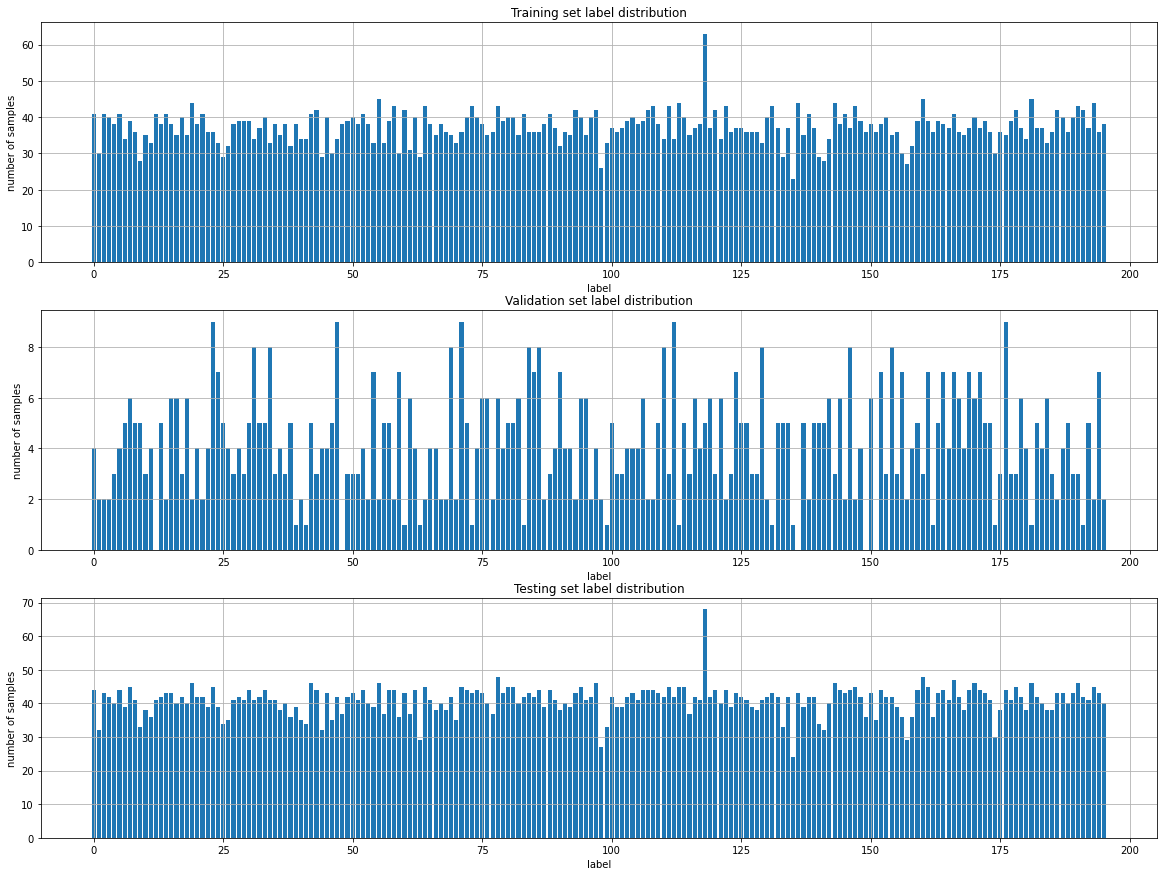

In [ ]:
plt.rcParams['figure.figsize'] = [20,15]
plt.subplot(311)
plt.bar(np.arange(196),train_label_counter)
plt.title('Training set label distribution')
plt.xlabel('label')
plt.ylabel('number of samples')
plt.grid()

plt.subplot(312)
plt.bar(np.arange(196),val_label_counter)
plt.title('Validation set label distribution')
plt.xlabel('label')
plt.ylabel('number of samples')
plt.grid()

plt.subplot(313)
plt.bar(np.arange(196),test_label_counter)
plt.title('Testing set label distribution')
plt.xlabel('label')
plt.ylabel('number of samples')
plt.grid()
plt.show()


# Part B: Neural Network Architecture

The main backbone for deep learning is the actual neural network architecture.  For image classification, this will consist of some combination of `Conv2d` layers with activations--usually `ReLU`--with intermittent downsampling--usually done using `MaxPool2d`--followed by a few Linear layers.  The input to the network should be an image with shape `(batch_size, channels, image_height, image_width)`(e.g. a single RGB image with dimensions 224x224 would be `(1, 3, 224, 224)`) and the output a vector of shape `(num_classes,)`, where the largest value's index in the output vector indicates the class label.  

While we built our own network in the Learning Lab, for this lab we will used one of Pytorch's pretrained networks. This has the benefit of already having learned features from training on an ImageNet classification problem. To pull in this pretrained network, we use the following line of code:

In [ ]:
import torchvision

model = torchvision.models.resnet18(pretrained=True)

print(list(model.__dict__["_modules"].keys()))

['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3', 'layer4', 'avgpool', 'fc']


The ResNet18 is a state of the art network that uses convolution layers, batch normalization, layers of residual blocks, and a fully connected layer at the end. The different layers are listed above. However, because the pretrained network was trained on ImageNet, the last layer is designed to predict 1000 classes, not 196 like in our dataset.

In [ ]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


Our goal is to use the same architecture as the ResNet, but replace the last fully connected layer with a new fully connected layer that goes from 512 input features to 196 output features.

PyTorch provides a nice framework for making a neural network architecture.  A network is typically made as a class that inherits from PyTorch's `Module` class and implements the `forward` method.  A network might take the form of the example below. PyTorch also provides a simple Neural Network [tutorial here](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) -- the Training a Classifier tutorial is especially helpful.
```Python
import torch.nn as nn 

class MyNetwork(nn.Module):
    def __init__(self):
        super(MyNetwork, self).__init__()
#         TODO: setup network here

    def forward(self, x):
#         TODO: perform the forward pass, which happens when someone calls network(x)
```

Take all the pretrained layers from ResNet18, but then define your own last fully connected layer. Then write the appropriate forward pass function.

**Note:** ResNet was trained with images that are normalized according to the ImageNet color averages. This means you may want to include an appropriate normalization in your Dataset class if you did not already. This can easily be done with Pytorch's transform objects.

```Python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
```

In [5]:
# Your Code Here
class Net(nn.Module):
  def __init__(self, output_size=196, resnet_version=18, start_frozen=False):
      super(Net, self).__init__()

      self.resnet_version = resnet_version
      if resnet_version == 18:
        self.model = resnet18(pretrained=True)
      elif resnet_version == 34:
        self.model = resnet34(pretrained=True)
      elif resnet_version == 50:
        self.model = resnet50(pretrained=True)
      elif resnet_version == 101:
        self.model = resnet101(pretrained=True)
      elif resnet_version == 152:
        self.model = resnet152(pretrained=True)
      else:
        self.model = resnet50(pretrained=True)

      self.model.fc = nn.Linear(self.model.fc.in_features, output_size)

      if start_frozen:
        for param in self.model.parameters():
          param.requires_grad = False

  def unfreeze(self, n_layers):
      ct = n_layers - 1
      if n_layers == 1:
        for param in self.model.fc.parameters():
          param.requires_grad = True
        return

      for name, param in reversed(list(self.model.named_parameters())):
        if self.resnet_version > 34:
          if 'conv2' in name: # conv1 and conv3 are bottleneck layers
            param.requires_grad = True
            ct -= 1
            if ct == 0: return
        else:
          if 'conv' in name:
            param.requires_grad = True
            ct -= 1
            if ct == 0: return
            
      for name, param in self.model.named_parameters():
        param.requires_grad = True # The first conv1 layer
        return
  
  def forward(self, x):
      return self.model(x)

# Part C: Training

Now that you can access your data and you have a network architecture set up, its time to put things together and start training.  Training requires two additional major components: 1) the loss function and 2) the optimizer.  The loss function is a comparison between your results and the ground truth data.  The optimizer is what takes the results of the loss function and backpropagates the error to the network weights in an attempt to decrease the loss.  The most common loss function used for classification is [Cross Entropy](https://pytorch.org/docs/stable/nn.html#crossentropyloss) while the most commonly used optimizer is [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).  

A basic training step might take the following form:
```Python
optimizer.zero_grad()
outs = model(inputs)
loss = loss_func(outs, labels)  # loss_func would be an instance of a torch.nn.CrossEntropyLoss class
loss.backward()
optimizer.step()  # optimizer would be an instance of the torch.optim.Adam class
```

For deliverables on this section, please display a plot of the value of the loss over time.  If things are working, the loss should be decreasing.

**Note: This step could take several hours so you will want to look into being able to save your model to a file and load it up again.** See [here](https://pytorch.org/docs/stable/notes/serialization.html).

Also, if you are running on Google Colab, your notebook may eventually get disconnected -- Colab limits the amount of time you can spend using their service at one time. You may want to save intermediate results to your Google Drive: see [here](https://medium.com/@ml_kid/how-to-save-our-model-to-google-drive-and-reuse-it-2c1028058cb2).

In [21]:
# Hyper-parameters
args = {
    'epoch': 10,
    'lr': 3e-4,
    'batch_size': 64,
    'test_every_n_epochs': 2
}

In [7]:
# Dataset and dataloader
car_test_data = CarDataset(root=root, download=True, transform=compose, train=False)
car_train_valid_data = CarDataset(root=root, download=True, transform=compose, train=True)
train_size = int(0.9*len(car_train_valid_data))
val_size = len(car_train_valid_data) - train_size

car_train_data, car_val_data = random_split(car_train_valid_data, [train_size, val_size])
train_loader = DataLoader(car_train_data, batch_size=args['batch_size'], num_workers=2, pin_memory=True)
val_loader = DataLoader(car_val_data, batch_size=args['batch_size'], num_workers=2, pin_memory=True)
test_loader = DataLoader(car_test_data, batch_size=args['batch_size'], num_workers=2, pin_memory=True)

  0%|          | 0/977350468 [00:00<?, ?it/s]

  0%|          | 0/979269282 [00:00<?, ?it/s]

In [ ]:
# Models
resnet_18 = Net(resnet_version=18, start_frozen=False)
resnet_18.to(device)
resnet_34 = Net(resnet_version=34, start_frozen=False)
resnet_34.to(device)
resnet_50 = Net(resnet_version=50, start_frozen=False)
resnet_50.to(device)

In [23]:
@torch.no_grad()
def test(model, validation=True, compute_matrix=True):
    model.eval()
    confusion_matrix = np.zeros((196,196))
    total_num_correct = 0
    batch = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss()
    data_loader = val_loader if validation else test_loader

    for batch, sample in enumerate(data_loader):
      x = sample['image'].cuda(non_blocking=True)
      y = sample['label'].cuda(non_blocking=True)
      batch += 1

      y_hat = model(x)
      total_loss += criterion(y_hat, y)
      prediction = torch.argmax(y_hat, dim=1)
      ground_truth = torch.argmax(y,dim=1)

      num_correct = torch.eq(prediction, ground_truth).sum().item()
      total_num_correct += num_correct

      if compute_matrix and not validation:
        for i in range(ground_truth.shape[-1]):
          confusion_matrix[ground_truth[i].item()][prediction[i].item()] += 1
      
    model.train()
    if validation:
      acc = total_num_correct / len(car_val_data)
    else:
      acc = total_num_correct / len(car_test_data)
    return acc, total_loss/batch, confusion_matrix

In [37]:
# Your Code Here
def train(model, model_unfreeze=0):
    """Fine-tunes a ResNet
    Args:
        start_frozen (bool): whether to start with the network weights frozen.
        model_unfreeze (int): the maximum number of network layers to unfreeze
    """
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    val_accs = []
    test_accs = []


    for epoch in range(args['epoch']):
      loop = tqdm(total=len(train_loader), position=0, leave=False)

      if epoch < model_unfreeze:
        # Unfreeze the last layers, one more each epoch
        model.unfreeze(epoch+1)

      if epoch == args['epoch'] / 2:
        for g in optimizer.param_groups:
          g['lr'] = 3e-5

      for batch, sample in enumerate(train_loader):
        x = sample['image'].cuda(non_blocking=True)
        y = sample['label'].cuda(non_blocking=True)

        optimizer.zero_grad()
        y_hat = model(x)

        loss = criterion(y_hat, y)
        loss.backward()
        train_losses.append(loss.item())

        loop.set_description('\tepoch:{}, loss:{:.4f}'.format(epoch, loss))
        loop.update(1)

        optimizer.step()

      val_acc, val_loss, confusion_matrix = test(model, validation=True, compute_matrix=False)
      val_accs.append(val_acc)

      if (epoch+1) % args['test_every_n_epochs'] == 0:
        test_acc, test_loss, confusion_matrix = test(model, validation=False, compute_matrix=False)
        test_accs.append(test_acc)
      loop.close()

      print('\tepoch:{}, validation accuracy:{:.2f}%, training loss:{:.4f}'.format(epoch, val_acc*100, train_losses[-1]))
    
    return train_losses, val_accs, test_accs

In [40]:
print('Training ResNet 34')
res34_train_losses, _, res34_test_accs = train(model=resnet_34, model_unfreeze=0)
print('\nTraining ResNet 18')
res18_train_losses, _, res18_test_accs = train(model=resnet_18, model_unfreeze=0)
print('\nTraining ResNet 50')
res50_train_losses, _, res50_test_accs = train(model=resnet_50, model_unfreeze=0)

Training ResNet 34


	epoch:0, validation accuracy:33.01%, training loss:2.8296


	epoch:1, validation accuracy:54.72%, training loss:0.9845


	epoch:2, validation accuracy:60.49%, training loss:0.3314


	epoch:3, validation accuracy:58.77%, training loss:0.1874


	epoch:4, validation accuracy:65.89%, training loss:0.0590


	epoch:5, validation accuracy:78.53%, training loss:0.0363


	epoch:6, validation accuracy:79.51%, training loss:0.0164


	epoch:7, validation accuracy:80.49%, training loss:0.0222


	epoch:8, validation accuracy:79.75%, training loss:0.0384


	epoch:9, validation accuracy:79.75%, training loss:0.0111

Training ResNet 18


	epoch:0, validation accuracy:31.41%, training loss:3.1566


	epoch:1, validation accuracy:49.69%, training loss:1.2000


	epoch:2, validation accuracy:63.44%, training loss:0.3466


	epoch:3, validation accuracy:73.13%, training loss:0.1381


	epoch:4, validation accuracy:73.25%, training loss:0.0633


	epoch:5, validation accuracy:78.28%, training loss:0.0425


	epoch:6, validation accuracy:79.88%, training loss:0.0455


	epoch:7, validation accuracy:80.49%, training loss:0.0399


	epoch:8, validation accuracy:80.25%, training loss:0.0309


	epoch:9, validation accuracy:80.61%, training loss:0.0306

Training ResNet 50


	epoch:0, validation accuracy:29.57%, training loss:2.8425


	epoch:1, validation accuracy:54.72%, training loss:1.2161


	epoch:2, validation accuracy:58.28%, training loss:0.5301


	epoch:3, validation accuracy:65.40%, training loss:0.2207


	epoch:4, validation accuracy:69.57%, training loss:0.1220


	epoch:5, validation accuracy:82.33%, training loss:0.0397


	epoch:6, validation accuracy:83.44%, training loss:0.0428


	epoch:7, validation accuracy:82.45%, training loss:0.0268


	epoch:8, validation accuracy:82.58%, training loss:0.0222


	epoch:9, validation accuracy:83.80%, training loss:0.0216


In [62]:
# ResNet 101
resnet_101 = Net(resnet_version=101, start_frozen=False)
resnet_101.to(device)
print('Training ResNet 101')
res101_train_losses, _, res101_test_accs = train(model=resnet_101, model_unfreeze=0)

Training ResNet 101


	epoch:0, validation accuracy:20.49%, training loss:2.7988


	epoch:1, validation accuracy:45.52%, training loss:1.3406


	epoch:2, validation accuracy:58.65%, training loss:0.5865


	epoch:3, validation accuracy:67.12%, training loss:0.3471


	epoch:4, validation accuracy:68.22%, training loss:0.2389


	epoch:5, validation accuracy:82.21%, training loss:0.0791


	epoch:6, validation accuracy:83.56%, training loss:0.0256


	epoch:7, validation accuracy:83.80%, training loss:0.0294


	epoch:8, validation accuracy:84.29%, training loss:0.0223


	epoch:9, validation accuracy:83.44%, training loss:0.0186


In [68]:
# Unfreezing ResNet 50
resnet50_frozen = Net(resnet_version=50, start_frozen=True)
resnet50_frozen.to(device)
print('Training ResNet 50 - unfreeze gradually')
res50_unfreezing_train_losses, _, res50_unfreezing_test_accs = train(model=resnet_50, model_unfreeze=20)

Training ResNet 50 - unfreeze gradually


	epoch:0, validation accuracy:60.86%, training loss:0.1993


	epoch:1, validation accuracy:65.40%, training loss:0.1382


	epoch:2, validation accuracy:63.31%, training loss:0.0678


	epoch:3, validation accuracy:69.57%, training loss:0.1581


	epoch:4, validation accuracy:67.73%, training loss:0.0502


	epoch:5, validation accuracy:83.07%, training loss:0.0056


	epoch:6, validation accuracy:82.70%, training loss:0.0256


	epoch:7, validation accuracy:84.91%, training loss:0.0127


	epoch:8, validation accuracy:83.56%, training loss:0.0051


	epoch:9, validation accuracy:83.93%, training loss:0.0033


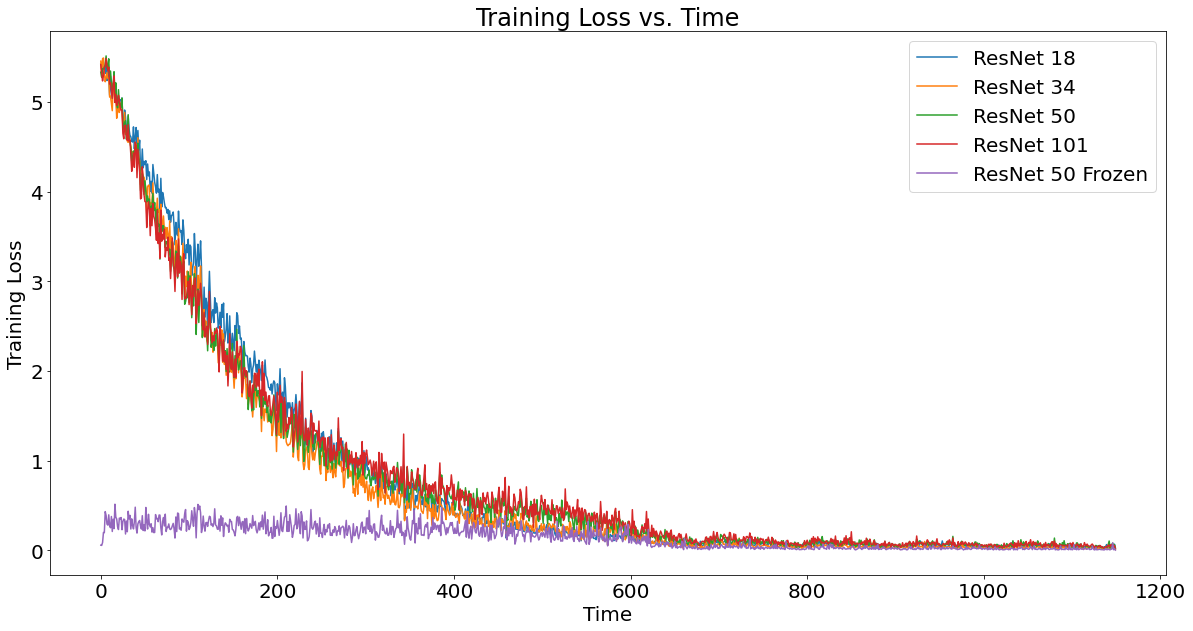

In [70]:
plt.rcParams['figure.figsize'] = [20,10]
plt.rcParams['font.size'] = 20
plt.subplot()
plt.plot(res18_train_losses, label='ResNet 18')
plt.plot(res34_train_losses, label='ResNet 34')
plt.plot(res50_train_losses, label='ResNet 50')
plt.plot(res101_train_losses, label='ResNet 101')
plt.plot(res50_unfreezing_train_losses, label='ResNet 50 Frozen')
plt.title('Training Loss vs. Time')
plt.ylabel('Training Loss')
# plt.yscale('log')
plt.xlabel('Time')
plt.legend()
plt.show()

# Part D: Testing

One of the goals of deep learning is to make a model that generalizes to data it has never seen (e.g. new images of cars).  For this part, you will test your generalizability by running the model on a dataset it has not yet seen during training.  To do so, you will need to make sure you are not calculating any gradients by using `torch.no_grad` in a with statement. You will also need to put the network into evaluation mode:
```Python
model.eval()
with torch.no_grad():
    # enter testing code here
```

To put the network back into training mode, call `model.train()`.

You will also need to compare your actual predictions with the ground truth, value for value.  The output of your network, however, will be a vector of length 196 (the number of possible classes for the cars dataset) with the largest value representing the guessed class.  You will need to extract the predicted class number and compare it with the ground truth class number for all images in the test dataset and calculate the overall accuracy.  **Print out the overall accuacy of your model**.

Additionally, **you will need to generate a confusion matrix of the 196 categories**. A confusion matrix shows how often a specific category is guessed as each other category. For example, the 11th row and 34th column in the matrix should tell you how many times category 11 images were guessed to be category 34 images. Thus, a perfect predictor on the test set would have nonzero values only along the diagnol. Once you generated the confusion matrix, you may simply plot it as a grayscale image (with interpolation turned off).

While high test accuracy is not the only goal in this lab, most students are able to get above 50% in their testing accuracy. If you are unable to reach this level of accuracy, it may indicate an error in your code.

In [53]:
# For confusion matrix
test_acc, test_loss, confusion_matrix = test(resnet_50, validation=False, compute_matrix=True)

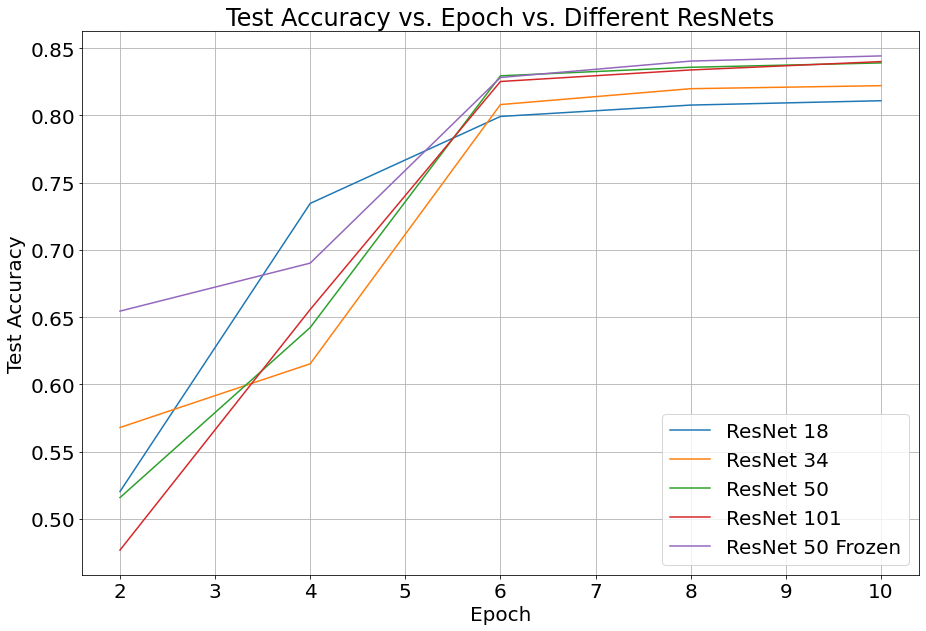

Test accuracy after 10 epochs:
ResNet 18: 81.10%
ResNet 34: 82.22%
ResNet 50: 83.91%
ResNet 101: 84.01%
ResNet 50 Frozen: 84.43% (the highest)


In [75]:
# Plot Test Accuracy vs. Epoch vs. Different ResNets
plt.rcParams['figure.figsize'] = [15,10]
plt.subplot()
epoch_x = [2,4,6,8,10]
plt.plot(epoch_x, res18_test_accs, label='ResNet 18')
plt.plot(epoch_x, res34_test_accs, label='ResNet 34')
plt.plot(epoch_x, res50_test_accs, label='ResNet 50')
plt.plot(epoch_x, res101_test_accs, label='ResNet 101')
plt.plot(epoch_x, res50_unfreezing_test_accs, label='ResNet 50 Frozen')
plt.title('Test Accuracy vs. Epoch vs. Different ResNets')
plt.ylabel('Test Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()
print('Test accuracy after {:} epochs:'.format(args['epoch']))
print('ResNet 18: {:.2f}%'.format(res18_test_accs[-1]*100))
print('ResNet 34: {:.2f}%'.format(res34_test_accs[-1]*100))
print('ResNet 50: {:.2f}%'.format(res50_test_accs[-1]*100))
print('ResNet 101: {:.2f}%'.format(res101_test_accs[-1]*100))
print('ResNet 50 Frozen: {:.2f}% (the highest)'.format(res50_unfreezing_test_accs[-1]*100))

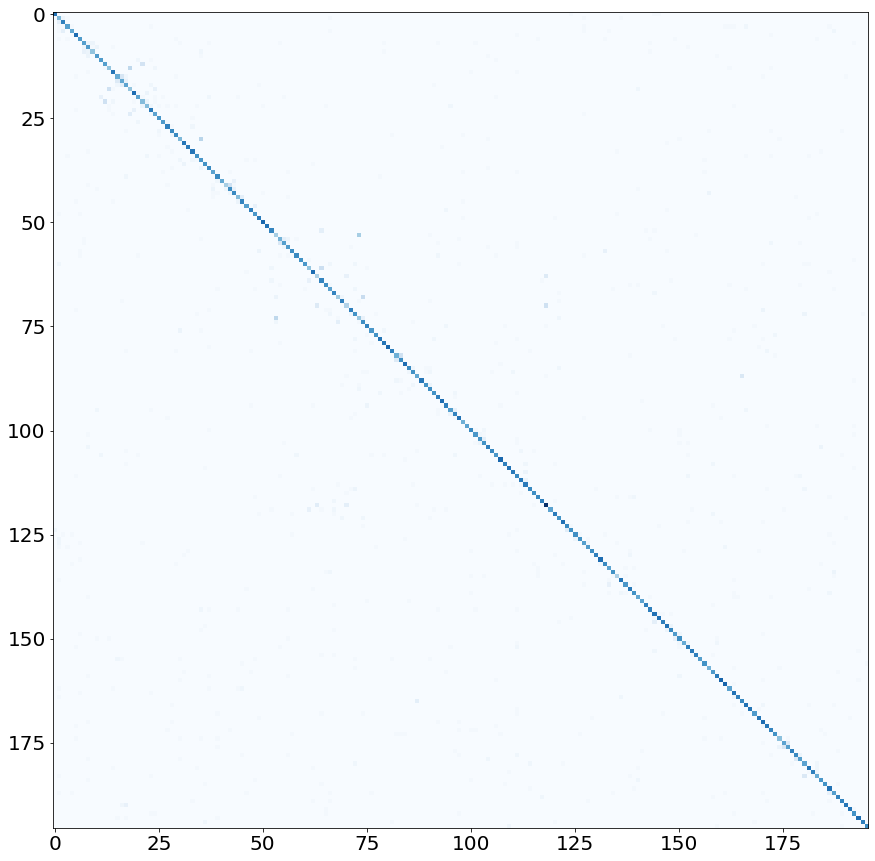

In [56]:
plt.rcParams['figure.figsize'] = [15,15]
plt.subplot()
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)

## Grading
Points for this assigment will be assigned as follows (100 points total):
* [20 pts] Making a Dataset class
* [10 pts] Setting up you architecture
* [20 pts] Training your model and plotting training loss
* [30 pts] Displaying the overall accuracy of your model and a confusion matrix

The last 20 points are earned through completing a subset of the following explorations:
* [10 pts] Enhance your dataloader to include reflection data augmentation (i.e. double the size of your training data by taking the mirror image across the y-axis). **DO NOT** do reflection augmentation across the x-axis (we don't care to detect cars when they are upside down!). Describe what effects the augmentation had on testing accuracy.
* [10 pts] Enhance your dataloader to include random resized crop data augmentation (i.e. increase the size of your training data by taking a subsection of your image each time). Make sure the crop is not too small, otherwise you might miss parts of the car. Describe what effects the augmentation had on testing accuracy.
* [10 pts] Analyze the effect of learning rates on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of changing the number of training epochs on the accuracy of the network. Describe what you found and give supporting plots.
* [10 pts] Analyze the effect of varying the batch_size on the accuracy of the network. Describe what you found and give supporting plots. 
* [10 pts] Analyze the effect of different optimizers on the accuracy of the network. Describe what you found and give supporting plots. A list of optimizers in Pytorch can be found [here](https://pytorch.org/docs/stable/optim.html).
* [10 pts] Analyze the effect of different pretrained networks on the accuracy of the network. Describe what you found and give supporting plots. A list of pretrained networks in Pytorch can be found [here](https://pytorch.org/docs/stable/torchvision/models.html).

You may earn up to 10 points extra credit for additional explorations you complete.

An additional 15 points of extra credit will be given to the individual with the highest test accuracy.


## Write-up:
Provide an explanation for the following items:
* Which part of this lab did you find most difficult?
* What insight did you gain from analyzing the confusion matrix?
* What insight did you gain from your explorations?
* What improvements would you recommend for this lab?

Your Write-up Here
- I found the part A most difficult. My goal is to set up this notebook so that anyone can run it on google colab without uploading extra files. So I did not use the provided json files at all. Instead, I directly downloaded everything from the stanford-cars website, including images and labels. I spent most of my time trying to write the download and extraction part. I think the hours I put in are worth it because I learned a lot about managing downloads and files in colab.
- My model is doing a pretty good job according to the confusion matrix. One thing interesting I found about the confusion matrix is that it seems like to be pretty symmetric. I guess there are certain pairs of car models that cannot be distinguished by the model.
- I tried: 1) random crop, 2) different epochs, and 3) different ResNet models. 
- - Random crop makes the test accuracy increase a little bit. 
- - More epochs lead to higher final test accuracy. After epoch 6 the test accuracy grows much more slowly. It might be caused by my learning rate. If I have time I would like to try using a scheduler to dynamically change the learning rate during training. 
- - ResNet with more layers performed better than with less layers. Models with less layers seem to learn faster due to their less amount of parameters but eventually they will end up with a lower test accuracy. My best model for now is a ResNet 50 with unfreezing mechanism. I think it can still perform better if I train it longer than 10 epochs.
- Although I enjoy doing part 1, I think we should focus more on the training and testing part of the lab instead of building a dataset from scratch.